
### Entrada
- x1: Local da Coleta em km
- x2: Nivel da Mare em m
- x3: Umidade do Ar (%)
- x4: Índice Pluvimétrico (mm)¹
- x5: Temperatura (°C)

### Saida
- y1: pH
- y2: Condutividade Elétrica (mS.cmˉ¹)
- y3: Oxigênio Dissolvido (mg.Lˉ¹)
- y4: Sólidos Totais Dissolvidos (ppm)


In [1]:
!pip install --upgrade pip
!pip install tensorflow 
!pip install openpyxl

In [2]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

/tmp/ipykernel_2294/1883313200.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


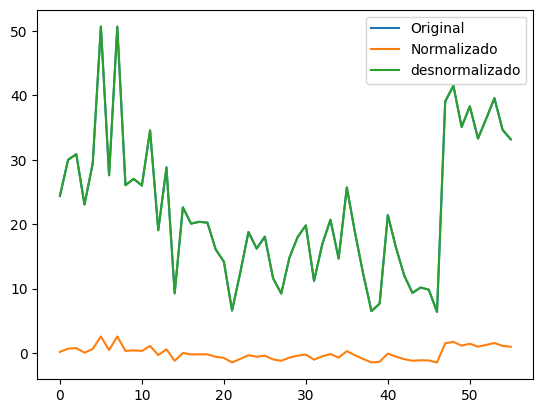

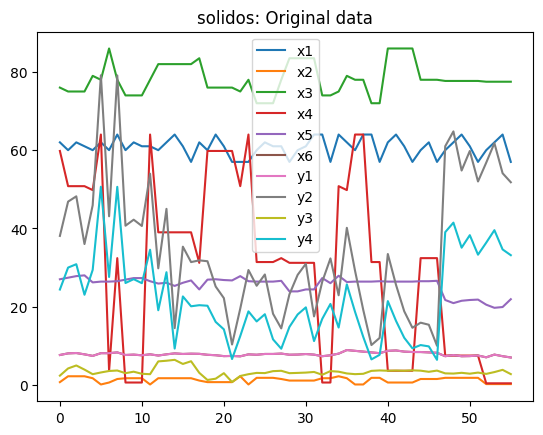

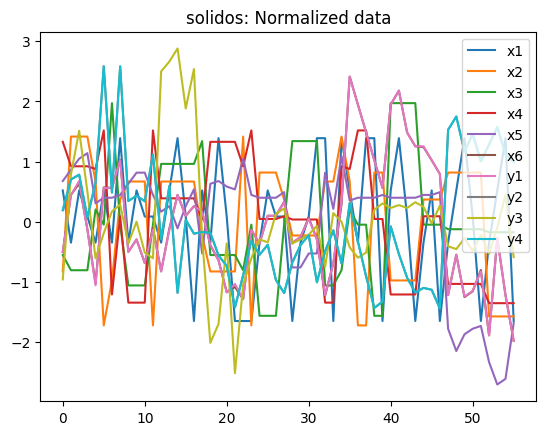

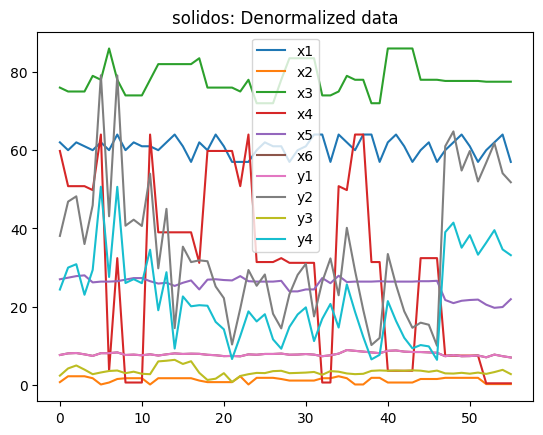

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def getData():
    df_orig = pd.read_excel("../../../data.xlsx")    
    df = pd.DataFrame(scaler.fit_transform(df_orig), columns=df_orig.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df), columns=df.columns)
    return (df_orig, df, df_denorm)

def create_dataframe(df, output):
    x1, x2, x3, x4, x5, x6  = df['x1'], df['x2'], df['x3'], df['x4'], df['x5'], df['x6']

    input = np.vstack([x1, x2, x3, x4, x5, x6 ]).T
    output = np.array(df[output])
    scaler.fit(output.reshape(-1, 1))
    return output, input

def test_out_scaler():
    out = df_orig["y4"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()

def show_norm(label):
    df_orig.plot(title=f"{label}: Original data")
    df.plot(title=f"{label}: Normalized data")
    df_denorm.plot(title=f"{label}: Denormalized data")

df_orig, df, df_denorm = getData()
output, input = create_dataframe(df, output="y4")
test_out_scaler()
show_norm(label="solidos")


In [4]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer
        
        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-05-18 01:13:10.524696: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-18 01:13:10.557287: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-18 01:13:10.557338: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-18 01:13:10.558424: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-18 01:13:10.564146: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-18 01:13:10.565057: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [5]:
import tensorflow as tf
import time
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
    
    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)

      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, input, output):
      input_train, input_vt, output_train, output_vt = train_test_split(input, output, test_size=0.3, shuffle = True)
      input_val, input_test, output_val, output_test = train_test_split(input_vt, output_vt, test_size=0.5, shuffle = True)

      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(input_test, output_test)
      self.vt_dataset, self.vt_input, self.vt_output = self.create_dataset(input_vt, output_vt)
      self.dataset, self.input, self.output = self.create_dataset(input, output)

      self._data = (input, output)
      self._train = (input_train, output_train)
      self._vt = (input_vt, output_vt)
      self._val = (input_val, output_val)
      self._test = (input_test, output_test)
    
    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)

      t2_start = time.perf_counter()
      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      t2_stop = time.perf_counter()
      print("Elapsed time: ", t2_stop - t2_start)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)

    def get_metrics(self):
    # Calculando a saida com os dados normalizados
      pred = self.lm_model.predict(self.input).flatten()
      test_pred = self.lm_model.predict(self.test_input).flatten()
      val_pred = self.lm_model.predict(self.val_input).flatten()
      vt_pred = self.lm_model.predict(self.vt_input).flatten()
  
    # Calculando as metricas com a saida desnormalizada
      self.pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
      test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
      val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
      vt_pred_denorm = out_scaler.inverse_transform(vt_pred.reshape(-1, 1))

      self.out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
      test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
      val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
      vt_denorm = out_scaler.inverse_transform(self._vt[1].reshape(-1, 1))      

      r2 = r2_score(self.out_denorm, self.pred_denorm)
      r2_test = r2_score(test_denorm, test_pred_denorm)
      r2_val = r2_score(val_denorm, val_pred_denorm)
      r2_vt = r2_score(vt_denorm,  vt_pred_denorm)

      mse = mean_squared_error(self.out_denorm, self.pred_denorm)
      mse_test = mean_squared_error(test_denorm, test_pred_denorm)
      mse_val = mean_squared_error(val_denorm, val_pred_denorm)
      mse_vt = mean_squared_error(vt_denorm,  vt_pred_denorm)

      metrics = {
                      'r2': r2,
                      'r2_test': r2_test,
                      'r2_val': r2_val,
                      'r2_vt': r2_vt,
                      'mse': mse,
                      'mse_test': mse_test,
                      'mse_val': mse_val,
                      'mse_vt': mse_vt
                      }

      return metrics

In [6]:
from itertools import product
import pickle

class Tester:
  def __init__(self, input, output, run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = input, output
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=6,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"../models/{fileName}.keras"
    open(path,'w').close()
    model.save_weights(path) 

  def SaveDataset(self, trainer, fileName):
    path = f"../dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._vt, trainer._val, trainer._test), f)

  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] >= boundarie): # should be <= to descending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    
    return(save)

# Init
  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinação {count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self.input, self.output)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults(sort_by, header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'../results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

In [7]:
tester = Tester(input, output, run_times=25, dataset_run_times=10)

In [8]:
tester.Loop(sort_by='r2',
            boundarie=0.8,
            hidden_sizes = [[30], [25], [20], [25, 15], [20, 10], [35], [10, 5], [30, 15]],
            regularizers=[0.01, 0.1],
            learning_rate=[0.1])

Testando combinação 1: Hidden Size=[30], regularizer=0.01, learning_rate=0.1
+++++++++++ [1_0] | 1 ++++++++++++++++++
Elapsed time:  0.840343983999901
Stopped at epoch:  7
1/1 [==============================] - 0s 16ms/step
+++++++++++ [1_0] | 2 ++++++++++++++++++
Elapsed time:  0.16322246899994752
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [1_0] | 3 ++++++++++++++++++
Elapsed time:  0.15465506100008497
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_0] | 4 ++++++++++++++++++
Elapsed time:  0.15722686899994187
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_0] | 5 ++++++++++++++++++
Elapsed time:  0.15285594300007688
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_0] | 6 ++++++++++++++++++
Elapsed time:  0.15110771300010128
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_0] | 7 +++++++++

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_1_2_0,0.803024,0.732908,-1.716651,0.335297,23.755402,29.210623,104.893730,64.826239
model_1_2_1,0.811225,0.743535,-1.711308,0.342602,22.766336,28.048413,104.687423,64.113832
model_1_2_2,0.817930,0.752565,-1.707044,0.348757,21.957721,27.060852,104.522815,63.513543
model_1_2_3,0.823413,0.760212,-1.703576,0.353943,21.296489,26.224570,104.388901,63.007777
model_1_2_4,0.827897,0.766668,-1.700704,0.358311,20.755695,25.518461,104.278010,62.581790
model_1_2_5,0.831565,0.772106,-1.698287,0.361989,20.313313,24.923759,104.184692,62.223021
model_1_2_6,0.834566,0.776676,-1.696226,0.365087,19.951362,24.423911,104.105091,61.920941
model_1_2_7,0.837022,0.780512,-1.694448,0.367695,19.655138,24.004401,104.036455,61.666544
model_1_2_8,0.839033,0.783727,-1.692900,0.369893,19.412629,23.652747,103.976672,61.452242
model_1_2_9,0.840680,0.786421,-1.691540,0.371745,19.213985,23.358116,103.924156,61.271552


DataFrame salvo em ../results/metrics_1_2
+++++++++++ [1_3] | 1 ++++++++++++++++++
Elapsed time:  0.1584343639999588
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_3] | 2 ++++++++++++++++++
Elapsed time:  0.16053376900003968
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_3] | 3 ++++++++++++++++++
Elapsed time:  0.15053942400004416
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_3] | 4 ++++++++++++++++++
Elapsed time:  0.14835376700011693
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_3] | 5 ++++++++++++++++++
Elapsed time:  0.15056022199996733
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_3] | 6 ++++++++++++++++++
Elapsed time:  0.15128022499993676
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_3] | 7 ++++++++++++++++++
Elapsed time:  0.1506796

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_1_3_15,0.800319,0.297690,-1.046009,-0.068070,24.081549,67.748184,90.898535,78.642465
model_1_3_14,0.803893,0.303434,-0.984429,-0.046601,23.650544,67.194088,88.162731,77.061696
model_1_3_13,0.807743,0.309697,-0.917070,-0.023131,23.186307,66.589947,85.170134,75.333563
model_1_3_12,0.811865,0.316517,-0.843644,0.002448,22.689161,65.932081,81.908030,73.450196
model_1_3_11,0.816247,0.323926,-0.763959,0.030214,22.160707,65.217319,78.367867,71.405799
model_1_3_10,0.820862,0.331960,-0.677935,0.060212,21.604088,64.442385,74.546031,69.197044
model_1_3_9,0.825668,0.340648,-0.585662,0.092438,21.024524,63.604248,70.446582,66.824167
model_1_3_8,0.830597,0.350016,-0.487465,0.126818,20.430092,62.700621,66.083962,64.292781
model_1_3_7,0.835552,0.360074,-0.383960,0.163184,19.832420,61.730309,61.485521,61.615143
model_1_3_6,0.840402,0.370821,-0.276133,0.201255,19.247606,60.693660,56.695091,58.811954


DataFrame salvo em ../results/metrics_1_3
+++++++++++ [1_4] | 1 ++++++++++++++++++
Elapsed time:  0.16218399100011993
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_4] | 2 ++++++++++++++++++
Elapsed time:  0.1593060019999939
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_4] | 3 ++++++++++++++++++
Elapsed time:  0.1975940869999704
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_4] | 4 ++++++++++++++++++
Elapsed time:  0.15066543799980536
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_4] | 5 ++++++++++++++++++
Elapsed time:  0.19605885200007833
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [1_4] | 6 ++++++++++++++++++
Elapsed time:  0.19591628500006664
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [1_4] | 7 ++++++++++++++++++
Elapsed time:  0.15333533

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_1_4_0,0.819756,0.985181,0.891777,0.958670,21.737520,1.078976,4.729280,2.796767
model_1_4_1,0.851586,0.976279,0.882703,0.950842,17.898735,1.727146,5.125823,3.326518
model_1_4_2,0.876333,0.962708,0.868916,0.938922,14.914218,2.715232,5.728292,4.133146
model_1_4_3,0.895508,0.946361,0.852106,0.924501,12.601753,3.905496,6.462889,5.108974
model_1_4_4,0.910298,0.928530,0.833541,0.908702,10.818063,5.203770,7.274184,6.178086
model_1_4_5,0.921640,0.910100,0.814155,0.892312,9.450244,6.545709,8.121341,7.287181
model_1_4_6,0.930271,0.891667,0.794620,0.875876,8.409314,7.887852,8.974992,8.399439
model_1_4_7,0.936775,0.873631,0.775410,0.859765,7.624955,9.201007,9.814457,9.489685
model_1_4_8,0.941612,0.856257,0.756847,0.844226,7.041553,10.466017,10.625671,10.541145
model_1_4_9,0.945148,0.839712,0.739139,0.829420,6.615126,11.670740,11.399465,11.543081


DataFrame salvo em ../results/metrics_1_4
+++++++++++ [1_5] | 1 ++++++++++++++++++
Elapsed time:  0.15731617400001596
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_5] | 2 ++++++++++++++++++
Elapsed time:  0.15068712400011464
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_5] | 3 ++++++++++++++++++
Elapsed time:  0.15379244600012498
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_5] | 4 ++++++++++++++++++
Elapsed time:  0.1531540359999326
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_5] | 5 ++++++++++++++++++
Elapsed time:  0.1549982290000571
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_5] | 6 ++++++++++++++++++
Elapsed time:  0.15033921700000974
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_5] | 7 ++++++++++++++++++
Elapsed time:  0.15187516

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_1_5_24,0.951164,0.825305,0.849564,0.839719,5.889673,18.781891,19.971485,19.341698
model_1_5_23,0.951628,0.826207,0.851918,0.841363,5.833690,18.684949,19.658950,19.143300
model_1_5_22,0.952134,0.827196,0.854512,0.843173,5.772639,18.578571,19.314580,18.924927
model_1_5_21,0.952685,0.828280,0.857367,0.845162,5.706240,18.462040,18.935579,18.684883
model_1_5_20,0.953282,0.829466,0.860505,0.847345,5.634240,18.334567,18.519059,18.421382
model_1_5_19,0.953927,0.830759,0.863949,0.849738,5.556445,18.195502,18.061842,18.132610
model_1_5_0,0.954090,0.861914,0.985295,0.927256,5.536754,14.846031,1.952185,8.778338
model_1_5_18,0.954621,0.832168,0.867723,0.852357,5.472707,18.044104,17.560721,17.816629
model_1_5_17,0.955365,0.833696,0.871852,0.855216,5.383033,17.879755,17.012574,17.471663
model_1_5_16,0.956156,0.835350,0.876360,0.858329,5.287551,17.701914,16.414185,17.095918


DataFrame salvo em ../results/metrics_1_5
+++++++++++ [1_6] | 1 ++++++++++++++++++
Elapsed time:  0.16652024699988033
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [1_6] | 2 ++++++++++++++++++
Elapsed time:  0.15611873700004253
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_6] | 3 ++++++++++++++++++
Elapsed time:  0.1497744870000588
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_6] | 4 ++++++++++++++++++
Elapsed time:  0.1492632770000455
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_6] | 5 ++++++++++++++++++
Elapsed time:  0.15162135600007787
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_6] | 6 ++++++++++++++++++
Elapsed time:  0.14822817599997506
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [1_6] | 7 ++++++++++++++++++
Elapsed time:  0.19349918

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_1_6_0,0.956762,0.897632,0.974071,0.930963,5.214469,12.452897,2.529329,7.782983
model_1_6_1,0.961014,0.898713,0.970210,0.930008,4.701710,12.321427,2.905992,7.890634
model_1_6_2,0.964200,0.898813,0.966005,0.928354,4.317506,12.309210,3.316131,8.077172
model_1_6_3,0.966543,0.898178,0.961608,0.926200,4.034871,12.386451,3.745093,8.319929
model_1_6_24,0.966615,0.865898,0.900504,0.882879,4.026235,16.313323,9.705651,13.203830
model_1_6_23,0.966846,0.866679,0.901707,0.883815,3.998411,16.218287,9.588349,13.098315
model_1_6_22,0.967094,0.867536,0.903029,0.884843,3.968418,16.113999,9.459357,12.982401
model_1_6_21,0.967361,0.868475,0.904482,0.885971,3.936233,15.999802,9.317636,12.855254
model_1_6_20,0.967646,0.869501,0.906076,0.887206,3.901875,15.874958,9.162141,12.715986
model_1_6_19,0.967948,0.870621,0.907822,0.888557,3.865436,15.738779,8.991813,12.563736


DataFrame salvo em ../results/metrics_1_6
+++++++++++ [1_7] | 1 ++++++++++++++++++
Elapsed time:  0.3047872140000436
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [1_7] | 2 ++++++++++++++++++
Elapsed time:  0.20547862800003713
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_7] | 3 ++++++++++++++++++
Elapsed time:  0.15119550700001128
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_7] | 4 ++++++++++++++++++
Elapsed time:  0.1505954459998975
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_7] | 5 ++++++++++++++++++
Elapsed time:  0.14954203399997823
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_7] | 6 ++++++++++++++++++
Elapsed time:  0.14892018099999405
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_7] | 7 ++++++++++++++++++
Elapsed time:  0.14827324

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_1_7_0,0.971659,0.984816,0.971496,0.976511,3.417889,0.728825,3.707779,2.130689
model_1_7_1,0.975461,0.980745,0.969522,0.974038,2.959402,0.924261,3.964574,2.354993
model_1_7_2,0.978283,0.975224,0.967177,0.970909,2.619042,1.189279,4.269573,2.638826
model_1_7_24,0.980054,0.864868,0.927601,0.913284,2.405478,6.486453,9.417703,7.865877
model_1_7_23,0.980259,0.866915,0.928304,0.914333,2.380735,6.388170,9.326139,7.770753
model_1_7_3,0.980337,0.968749,0.964601,0.967357,2.371385,1.500087,4.604630,2.961048
model_1_7_22,0.980481,0.869169,0.929080,0.915488,2.354035,6.279966,9.225265,7.665987
model_1_7_21,0.980719,0.871649,0.929933,0.916759,2.325347,6.160951,9.114230,7.550728
model_1_7_20,0.980973,0.874372,0.930872,0.918155,2.294674,6.030236,8.992118,7.424064
model_1_7_19,0.981243,0.877359,0.931903,0.919687,2.262086,5.886872,8.858054,7.285077


DataFrame salvo em ../results/metrics_1_7
+++++++++++ [1_8] | 1 ++++++++++++++++++
Elapsed time:  0.16464309100001628
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [1_8] | 2 ++++++++++++++++++
Elapsed time:  0.15269443799979854
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_8] | 3 ++++++++++++++++++
Elapsed time:  0.15584301399985634
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_8] | 4 ++++++++++++++++++
Elapsed time:  0.15849507600000834
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_8] | 5 ++++++++++++++++++
Elapsed time:  0.1489489959999446
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [1_8] | 6 ++++++++++++++++++
Elapsed time:  0.3827930519998972
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_8] | 7 ++++++++++++++++++
Elapsed time:  0.20714434

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_1_8_0,0.983514,0.983143,0.996484,0.990639,1.988163,0.944973,0.221429,0.604481
model_1_8_1,0.986192,0.983761,0.993608,0.989604,1.665239,0.910309,0.402557,0.671367
model_1_8_2,0.988247,0.984191,0.989836,0.988070,1.417416,0.886233,0.640033,0.770374
model_1_8_3,0.989808,0.984469,0.985476,0.986197,1.229126,0.870626,0.914629,0.891334
model_1_8_4,0.990979,0.984629,0.980763,0.984108,1.087878,0.861681,1.211405,1.026257
model_1_8_5,0.991844,0.984696,0.975880,0.981898,0.983640,0.857882,1.518911,1.168955
model_1_8_24,0.992414,0.982668,0.916941,0.953919,0.914830,0.971595,5.230489,2.975780
model_1_8_6,0.992468,0.984695,0.970964,0.979641,0.908378,0.857972,1.828516,1.314698
model_1_8_23,0.992498,0.982742,0.918281,0.954567,0.904801,0.967446,5.146120,2.933879
model_1_8_22,0.992586,0.982822,0.919756,0.955281,0.894126,0.962923,5.053231,2.887776


DataFrame salvo em ../results/metrics_1_8
+++++++++++ [1_9] | 1 ++++++++++++++++++
Elapsed time:  0.19013195499996982
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_9] | 2 ++++++++++++++++++
Elapsed time:  0.14967991699995764
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_9] | 3 ++++++++++++++++++
Elapsed time:  0.15388847700000952
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_9] | 4 ++++++++++++++++++
Elapsed time:  0.24258332699992025
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_9] | 5 ++++++++++++++++++
Elapsed time:  0.15080361299988
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_9] | 6 ++++++++++++++++++
Elapsed time:  0.22982529799992335
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_9] | 7 ++++++++++++++++++
Elapsed time:  0.148423514

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_1_9_24,0.991859,0.950264,0.969543,0.960133,0.981778,3.748476,2.649152,3.231149
model_1_9_23,0.991885,0.950396,0.969677,0.960265,0.978731,3.738532,2.637536,3.220420
model_1_9_22,0.991912,0.950542,0.969824,0.960411,0.975398,3.727586,2.624708,3.208588
model_1_9_21,0.991942,0.950701,0.969987,0.960572,0.971756,3.715547,2.610534,3.195539
model_1_9_20,0.991975,0.950877,0.970167,0.960749,0.967786,3.702306,2.594871,3.181161
model_1_9_19,0.992011,0.951070,0.970366,0.960945,0.963470,3.687781,2.577593,3.165340
model_1_9_18,0.992050,0.951281,0.970585,0.961159,0.958788,3.671868,2.558519,3.147936
model_1_9_17,0.992092,0.951512,0.970826,0.961395,0.953733,3.654456,2.537538,3.128843
model_1_9_16,0.992137,0.951764,0.971092,0.961653,0.948295,3.635453,2.514424,3.107909
model_1_9_15,0.992185,0.952039,0.971384,0.961936,0.942472,3.614764,2.489027,3.085002


DataFrame salvo em ../results/metrics_1_9
Testando combinação 2: Hidden Size=[30], regularizer=0.1, learning_rate=0.1
+++++++++++ [2_0] | 1 ++++++++++++++++++
Elapsed time:  0.370259643000054
Stopped at epoch:  8
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_0] | 2 ++++++++++++++++++
Elapsed time:  0.15382310700010748
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_0] | 3 ++++++++++++++++++
Elapsed time:  0.14893441699996401
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_0] | 4 ++++++++++++++++++
Elapsed time:  0.16711724199990385
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [2_0] | 5 ++++++++++++++++++
Elapsed time:  0.21567071699996632
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_0] | 6 ++++++++++++++++++
Elapsed time:  0.14793540999994548
Stopped at epoch:  6
1/1 [==============================] - 0s 

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_2_4_5,0.800453,-0.148605,0.596972,0.493183,24.065467,100.705691,50.301596,76.986122
model_2_4_0,0.801174,-0.061322,0.605238,0.523050,23.978466,93.053074,49.269911,72.449222
model_2_4_4,0.801285,-0.133710,0.599940,0.498882,23.965045,99.399761,49.931137,76.120393
model_2_4_3,0.801889,-0.117565,0.602500,0.504805,23.892227,97.984255,49.611714,75.220702
model_2_4_1,0.801981,-0.081381,0.605471,0.517011,23.881146,94.811731,49.240904,73.366634
model_2_4_2,0.802164,-0.100130,0.604436,0.510882,23.859064,96.455565,49.370017,74.297641


DataFrame salvo em ../results/metrics_2_4
+++++++++++ [2_5] | 1 ++++++++++++++++++
Elapsed time:  0.21860669100010455
Stopped at epoch:  7
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_5] | 2 ++++++++++++++++++
Elapsed time:  0.17051965900009236
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_5] | 3 ++++++++++++++++++
Elapsed time:  0.15763160400001652
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_5] | 4 ++++++++++++++++++
Elapsed time:  0.15028004099985992
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_5] | 5 ++++++++++++++++++
Elapsed time:  0.21328368500007855
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [2_5] | 6 ++++++++++++++++++
Elapsed time:  0.2919967099999212
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [2_5] | 7 ++++++++++++++++++
Elapsed time:  0.3593247

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_2_5_0,0.828494,0.920574,0.473323,0.667024,20.683701,5.103621,68.847419,35.100711
model_2_5_1,0.842316,0.908420,0.468002,0.659997,19.016765,5.884551,69.542916,35.841430
model_2_5_2,0.852915,0.893904,0.462369,0.652025,17.738483,6.817304,70.279251,36.681752
model_2_5_3,0.860951,0.877684,0.456634,0.643445,16.769361,7.859520,71.028890,37.586276
model_2_5_4,0.866951,0.860306,0.450951,0.634520,16.045735,8.976172,71.771894,38.527103
model_2_5_24,0.871003,0.600569,0.391330,0.515910,15.557115,25.665818,79.565496,51.030366
model_2_5_5,0.871340,0.842226,0.445425,0.625461,15.516397,10.137911,72.494219,39.482065
model_2_5_23,0.871555,0.606589,0.392394,0.518474,15.490462,25.278964,79.426392,50.760096
model_2_5_22,0.872146,0.613193,0.393574,0.521293,15.419236,24.854648,79.272200,50.462907
model_2_5_21,0.872773,0.620426,0.394880,0.524389,15.343584,24.389907,79.101464,50.136510


DataFrame salvo em ../results/metrics_2_5
+++++++++++ [2_6] | 1 ++++++++++++++++++
Elapsed time:  0.15519754199999625
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_6] | 2 ++++++++++++++++++
Elapsed time:  0.1534099339999102
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_6] | 3 ++++++++++++++++++
Elapsed time:  0.15064620800012563
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_6] | 4 ++++++++++++++++++
Elapsed time:  0.1502844639999239
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [2_6] | 5 ++++++++++++++++++
Elapsed time:  0.1521714839998367
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_6] | 6 ++++++++++++++++++
Elapsed time:  0.1510832379999556
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_6] | 7 ++++++++++++++++++
Elapsed time:  0.1922284199

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_2_6_0,0.892516,0.814176,0.989511,0.887872,12.962585,25.097670,0.472661,13.509430
model_2_6_1,0.909882,0.834236,0.986061,0.899170,10.868270,22.388302,0.628112,12.148213
model_2_6_2,0.923876,0.850435,0.981845,0.908042,9.180523,20.200498,0.818072,11.079356
model_2_6_3,0.935133,0.863469,0.977112,0.914944,7.822942,18.440105,1.031345,10.247748
model_2_6_4,0.944170,0.873922,0.972038,0.920255,6.733099,17.028242,1.259972,9.607880
model_2_6_5,0.951410,0.882283,0.966758,0.924287,5.860006,15.899051,1.497927,9.122052
model_2_6_6,0.957197,0.888953,0.961377,0.927299,5.162083,14.998218,1.740371,8.759231
model_2_6_7,0.961812,0.894263,0.955985,0.929501,4.605458,14.280965,1.983355,8.493856
model_2_6_8,0.965484,0.898483,0.950652,0.931067,4.162646,13.711061,2.223644,8.305218
model_2_6_9,0.968397,0.901830,0.945439,0.932136,3.811335,13.258987,2.458550,8.176428


DataFrame salvo em ../results/metrics_2_6
+++++++++++ [2_7] | 1 ++++++++++++++++++
Elapsed time:  0.15829820999988442
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_7] | 2 ++++++++++++++++++
Elapsed time:  0.18907888400008233
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_7] | 3 ++++++++++++++++++
Elapsed time:  0.1496883570000591
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_7] | 4 ++++++++++++++++++
Elapsed time:  0.1507984969998688
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_7] | 5 ++++++++++++++++++
Elapsed time:  0.1669595329999538
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_7] | 6 ++++++++++++++++++
Elapsed time:  0.15701270799991107
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_7] | 7 ++++++++++++++++++
Elapsed time:  0.157191918

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_2_7_24,0.973530,0.914986,0.916293,0.917003,3.192258,11.856655,8.950469,10.489039
model_2_7_23,0.973790,0.915801,0.917272,0.917869,3.160930,11.742935,8.845843,10.379595
model_2_7_22,0.974074,0.916698,0.918351,0.918823,3.126681,11.617814,8.730469,10.259065
model_2_7_21,0.974384,0.917685,0.919540,0.919872,3.089300,11.480264,8.603314,10.126406
model_2_7_20,0.974721,0.918768,0.920848,0.921026,3.048604,11.329236,8.463383,9.980595
model_2_7_19,0.975088,0.919955,0.922288,0.922293,3.004415,11.163654,8.309509,9.820524
model_2_7_18,0.975484,0.921254,0.923868,0.923681,2.956591,10.982453,8.140535,9.645075
model_2_7_17,0.975912,0.922673,0.925601,0.925200,2.905023,10.784504,7.955262,9.453089
model_2_7_16,0.976371,0.924220,0.927498,0.926859,2.849659,10.568765,7.752406,9.243418
model_2_7_15,0.976861,0.925902,0.929570,0.928667,2.790529,10.334210,7.530776,9.014942


DataFrame salvo em ../results/metrics_2_7
+++++++++++ [2_8] | 1 ++++++++++++++++++
Elapsed time:  0.15844057899994368
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [2_8] | 2 ++++++++++++++++++
Elapsed time:  0.15362898199987285
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_8] | 3 ++++++++++++++++++
Elapsed time:  0.16336753499990664
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_8] | 4 ++++++++++++++++++
Elapsed time:  0.15272731300001396
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_8] | 5 ++++++++++++++++++
Elapsed time:  0.1569894279998607
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [2_8] | 6 ++++++++++++++++++
Elapsed time:  0.1963507739999386
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_8] | 7 ++++++++++++++++++
Elapsed time:  0.15119957

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_2_8_0,0.978412,0.998113,0.996648,0.997677,2.603534,0.287653,0.258070,0.273731
model_2_8_1,0.982091,0.998451,0.992615,0.996669,2.159779,0.236114,0.568493,0.392528
model_2_8_2,0.984812,0.998434,0.987172,0.994983,1.831650,0.238818,0.987544,0.591159
model_2_8_24,0.984906,0.984903,0.869570,0.949554,1.820294,2.301573,10.041061,5.943684
model_2_8_23,0.985151,0.985234,0.871852,0.950483,1.790832,2.251112,9.865389,5.834298
model_2_8_22,0.985415,0.985597,0.874362,0.951503,1.758979,2.195870,9.672193,5.714138
model_2_8_21,0.985699,0.985993,0.877119,0.952622,1.724668,2.135517,9.459940,5.582308
model_2_8_20,0.986004,0.986424,0.880143,0.953847,1.687881,2.069701,9.227135,5.437907
model_2_8_19,0.986330,0.986894,0.883455,0.955187,1.648656,1.998124,8.972182,5.280028
model_2_8_18,0.986674,0.987403,0.887075,0.956649,1.607113,1.920475,8.693504,5.107783


DataFrame salvo em ../results/metrics_2_8
+++++++++++ [2_9] | 1 ++++++++++++++++++
Elapsed time:  0.15656451400013793
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_9] | 2 ++++++++++++++++++
Elapsed time:  0.15136085300014201
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_9] | 3 ++++++++++++++++++
Elapsed time:  0.15041925499986064
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_9] | 4 ++++++++++++++++++
Elapsed time:  0.15156256600016604
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_9] | 5 ++++++++++++++++++
Elapsed time:  0.15541146400005346
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_9] | 6 ++++++++++++++++++
Elapsed time:  0.14927583999997296
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_9] | 7 ++++++++++++++++++
Elapsed time:  0.149289

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_2_9_0,0.986909,0.961211,0.996610,0.986522,1.578767,2.588160,0.526543,1.617988
model_2_9_1,0.988485,0.960119,0.996406,0.986077,1.388724,2.661054,0.558181,1.671467
model_2_9_2,0.989720,0.958932,0.996158,0.985576,1.239807,2.740273,0.596820,1.731590
model_2_9_3,0.990682,0.957697,0.995882,0.985045,1.123694,2.822645,0.639658,1.795357
model_2_9_4,0.991429,0.956452,0.995592,0.984502,1.033689,2.905750,0.684604,1.860504
model_2_9_5,0.992003,0.955222,0.995299,0.983962,0.964420,2.987823,0.730151,1.925388
model_2_9_6,0.992441,0.954027,0.995009,0.983434,0.911574,3.067537,0.775191,1.988785
model_2_9_7,0.992772,0.952881,0.994727,0.982925,0.871702,3.144006,0.818980,2.049878
model_2_9_8,0.993018,0.951793,0.994457,0.982440,0.842034,3.216612,0.860972,2.108076
model_2_9_9,0.993198,0.950767,0.994200,0.981982,0.820368,3.285029,0.900841,2.163058


DataFrame salvo em ../results/metrics_2_9
Testando combinação 3: Hidden Size=[25], regularizer=0.01, learning_rate=0.1
+++++++++++ [3_0] | 1 ++++++++++++++++++
Elapsed time:  0.7987408159999632
Stopped at epoch:  20
1/1 [==============================] - 0s 25ms/step
+++++++++++ [3_0] | 2 ++++++++++++++++++
Elapsed time:  0.39349135300017224
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [3_0] | 3 ++++++++++++++++++
Elapsed time:  0.3398191460000817
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_0] | 4 ++++++++++++++++++
Elapsed time:  0.14819462600007682
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_0] | 5 ++++++++++++++++++
Elapsed time:  0.1712458009999409
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [3_0] | 6 ++++++++++++++++++
Elapsed time:  0.15722621500003697
Stopped at epoch:  6
1/1 [==============================] - 0s

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_1_0,0.800766,0.910319,0.543720,0.922889,24.027664,8.204701,9.258048,8.700395
model_3_1_22,0.804125,0.100704,-2.516241,0.316391,23.622562,82.274915,71.345538,77.131662
model_3_1_21,0.806891,0.115812,-2.461036,0.327548,23.289060,80.892729,70.225421,75.872848
model_3_1_20,0.809874,0.132399,-2.400342,0.339805,22.929254,79.375161,68.993921,74.489873
model_3_1_19,0.813079,0.150589,-2.333701,0.353253,22.542702,77.710994,67.641754,72.972518
model_3_1_18,0.816505,0.170504,-2.260628,0.367986,22.129493,75.889013,66.159089,71.310252
model_3_1_17,0.820147,0.192273,-2.180629,0.384101,21.690297,73.897392,64.535882,69.491960
model_3_1_1,0.823126,0.858180,0.320971,0.881657,21.331085,12.974806,13.777700,13.352644
model_3_1_16,0.823991,0.216025,-2.093196,0.401696,21.226788,71.724365,62.761843,67.506702
model_3_1_15,0.828012,0.241885,-1.997831,0.420867,20.741825,69.358488,60.826855,65.343625


DataFrame salvo em ../results/metrics_3_1
+++++++++++ [3_2] | 1 ++++++++++++++++++
Elapsed time:  0.15506752999999662
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_2] | 2 ++++++++++++++++++
Elapsed time:  0.1542291400000977
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_2] | 3 ++++++++++++++++++
Elapsed time:  0.1475022770000578
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [3_2] | 4 ++++++++++++++++++
Elapsed time:  0.14693723899995348
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_2] | 5 ++++++++++++++++++
Elapsed time:  0.15757061099998282
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_2] | 6 ++++++++++++++++++
Elapsed time:  0.19053799599987542
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [3_2] | 7 ++++++++++++++++++
Elapsed time:  0.21948971

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_2_0,0.810635,0.739155,-0.305427,0.181802,22.837472,16.429528,118.669164,64.542320
model_3_2_1,0.815451,0.739786,-0.308729,0.180278,22.256659,16.389820,118.969403,64.662568
model_3_2_2,0.818958,0.739454,-0.314368,0.177080,21.833665,16.410693,119.481952,64.914807
model_3_2_24,0.819764,0.717363,-0.451896,0.093159,21.736535,17.802109,131.983937,71.534753
model_3_2_23,0.820044,0.717773,-0.449239,0.094774,21.702699,17.776278,131.742333,71.407354
model_3_2_22,0.820348,0.718226,-0.446316,0.096551,21.666132,17.747745,131.476652,71.267220
model_3_2_21,0.820674,0.718725,-0.443104,0.098503,21.626752,17.716362,131.184646,71.113202
model_3_2_20,0.821024,0.719274,-0.439579,0.100647,21.584519,17.681742,130.864249,70.944088
model_3_2_19,0.821398,0.719878,-0.435718,0.102996,21.539510,17.643721,130.513278,70.758795
model_3_2_3,0.821457,0.738539,-0.321587,0.172778,21.532280,16.468359,120.138202,65.254165


DataFrame salvo em ../results/metrics_3_2
+++++++++++ [3_3] | 1 ++++++++++++++++++
Elapsed time:  0.21550712500015834
Stopped at epoch:  9
1/1 [==============================] - 0s 17ms/step
+++++++++++ [3_3] | 2 ++++++++++++++++++
Elapsed time:  0.171634074999929
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_3] | 3 ++++++++++++++++++
Elapsed time:  0.1616125909999937
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [3_3] | 4 ++++++++++++++++++
Elapsed time:  0.14928785600000083
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_3] | 5 ++++++++++++++++++
Elapsed time:  0.15311301899987484
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_3] | 6 ++++++++++++++++++
Elapsed time:  0.1493200079999042
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [3_3] | 7 ++++++++++++++++++
Elapsed time:  0.2342493730

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_3_0,0.915647,0.979623,0.904646,0.952837,10.173012,3.600474,10.641192,6.913754
model_3_3_1,0.927721,0.974774,0.906094,0.950262,8.716842,4.457441,10.479498,7.291352
model_3_3_2,0.937189,0.970370,0.906687,0.947664,7.575027,5.235476,10.413323,7.672116
model_3_3_3,0.944642,0.966395,0.906856,0.945188,6.676170,5.937825,10.394502,8.035085
model_3_3_4,0.950512,0.962780,0.906776,0.942852,5.968260,6.576609,10.403476,8.377489
model_3_3_5,0.955121,0.959458,0.906498,0.940633,5.412397,7.163632,10.434514,8.702868
model_3_3_6,0.958717,0.956379,0.906022,0.938497,4.978717,7.707731,10.487619,9.015923
model_3_3_7,0.961495,0.953510,0.905336,0.936421,4.643657,8.214611,10.564151,9.320271
model_3_3_8,0.963614,0.950834,0.904437,0.934391,4.388194,8.687486,10.664414,9.617813
model_3_3_9,0.965201,0.948340,0.903338,0.932406,4.196725,9.128145,10.787086,9.908826


DataFrame salvo em ../results/metrics_3_3
+++++++++++ [3_4] | 1 ++++++++++++++++++
Elapsed time:  0.15851436299999477
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_4] | 2 ++++++++++++++++++
Elapsed time:  0.2386557999998331
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_4] | 3 ++++++++++++++++++
Elapsed time:  0.14801432899980682
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_4] | 4 ++++++++++++++++++
Elapsed time:  0.1472735830000147
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_4] | 5 ++++++++++++++++++
Elapsed time:  0.17742893600006937
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [3_4] | 6 ++++++++++++++++++
Elapsed time:  0.164950374
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_4] | 7 ++++++++++++++++++
Elapsed time:  0.1495493950001218

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_4_0,0.972071,0.977171,0.993097,0.985097,3.368198,2.668521,0.723687,1.753306
model_3_4_1,0.975846,0.973414,0.992410,0.982833,2.912957,3.107680,0.795735,2.019706
model_3_4_2,0.978640,0.969142,0.991237,0.980094,2.575979,3.607079,0.918672,2.341948
model_3_4_24,0.979718,0.899948,0.963402,0.932026,2.446005,11.695179,3.836872,7.997148
model_3_4_23,0.979939,0.901197,0.963900,0.932891,2.419374,11.549189,3.784659,7.895293
model_3_4_22,0.980177,0.902572,0.964451,0.933845,2.390601,11.388502,3.726968,7.783075
model_3_4_21,0.980434,0.904083,0.965058,0.934895,2.359643,11.211831,3.663274,7.659572
model_3_4_3,0.980663,0.964558,0.989730,0.977051,2.332008,4.142900,1.076703,2.699982
model_3_4_20,0.980709,0.905743,0.965728,0.936049,2.326488,11.017802,3.593030,7.523789
model_3_4_19,0.981002,0.907563,0.966466,0.937316,2.291192,10.805034,3.515631,7.374733


DataFrame salvo em ../results/metrics_3_4
+++++++++++ [3_5] | 1 ++++++++++++++++++
Elapsed time:  0.23618892400008917
Stopped at epoch:  7
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_5] | 2 ++++++++++++++++++
Elapsed time:  0.15665406400012216
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_5] | 3 ++++++++++++++++++
Elapsed time:  0.15252475700003743
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_5] | 4 ++++++++++++++++++
Elapsed time:  0.16555287500000304
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_5] | 5 ++++++++++++++++++
Elapsed time:  0.15503205900017747
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_5] | 6 ++++++++++++++++++
Elapsed time:  0.15016414500018982
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [3_5] | 7 ++++++++++++++++++
Elapsed time:  0.149522

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_5_0,0.983657,0.932578,0.997596,0.965200,1.970947,5.644849,0.200807,3.082948
model_3_5_1,0.984960,0.929658,0.997348,0.963629,1.813789,5.889294,0.221535,3.222106
model_3_5_24,0.985088,0.907984,0.953582,0.933367,1.798443,7.703950,3.876889,5.902979
model_3_5_23,0.985236,0.908234,0.954927,0.934089,1.780555,7.683009,3.764579,5.839040
model_3_5_22,0.985395,0.908495,0.956395,0.934871,1.761404,7.661156,3.641943,5.769762
model_3_5_21,0.985564,0.908765,0.957994,0.935716,1.741006,7.638523,3.508366,5.694915
model_3_5_20,0.985743,0.909042,0.959732,0.936625,1.719421,7.615337,3.363242,5.614354
model_3_5_19,0.985931,0.909323,0.961614,0.937601,1.696734,7.591815,3.206059,5.527928
model_3_5_2,0.985937,0.926886,0.996926,0.962055,1.695967,6.121358,0.256742,3.361541
model_3_5_18,0.986127,0.909604,0.963644,0.938642,1.673115,7.568259,3.036504,5.435675


DataFrame salvo em ../results/metrics_3_5
+++++++++++ [3_6] | 1 ++++++++++++++++++
Elapsed time:  0.3215583180001431
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [3_6] | 2 ++++++++++++++++++
Elapsed time:  0.3024191859999519
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_6] | 3 ++++++++++++++++++
Elapsed time:  0.15040110799986905
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_6] | 4 ++++++++++++++++++
Elapsed time:  0.146836932000042
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_6] | 5 ++++++++++++++++++
Elapsed time:  0.15137969399984286
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [3_6] | 6 ++++++++++++++++++
Elapsed time:  0.15203112699987287
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_6] | 7 ++++++++++++++++++
Elapsed time:  0.1499050889

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_6_0,0.987174,0.999149,0.980960,0.990401,1.546853,0.125679,2.949970,1.454757
model_3_6_1,0.988789,0.998895,0.980522,0.990059,1.352106,0.163238,3.017847,1.506584
model_3_6_2,0.990028,0.998569,0.979929,0.989607,1.202599,0.211311,3.109599,1.575211
model_3_6_3,0.990970,0.998192,0.979237,0.989079,1.088998,0.267001,3.216852,1.655166
model_3_6_4,0.991677,0.997780,0.978486,0.988505,1.003794,0.327844,3.333223,1.742139
model_3_6_5,0.992198,0.997347,0.977707,0.987907,0.940967,0.391776,3.453952,1.832799
model_3_6_24,0.992485,0.991637,0.968340,0.980455,0.906254,1.235186,4.905154,2.962230
model_3_6_23,0.992538,0.991776,0.968552,0.980629,0.899907,1.214663,4.872313,2.935909
model_3_6_6,0.992573,0.996905,0.976922,0.987301,0.895679,0.457098,3.575506,1.924584
model_3_6_22,0.992594,0.991929,0.968786,0.980820,0.893145,1.192118,4.836139,2.906953


DataFrame salvo em ../results/metrics_3_6
+++++++++++ [3_7] | 1 ++++++++++++++++++
Elapsed time:  0.15605859299989788
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [3_7] | 2 ++++++++++++++++++
Elapsed time:  0.15883865799992236
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_7] | 3 ++++++++++++++++++
Elapsed time:  0.20035902699987673
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_7] | 4 ++++++++++++++++++
Elapsed time:  0.21915597099996376
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [3_7] | 5 ++++++++++++++++++
Elapsed time:  0.3441811300001518
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [3_7] | 6 ++++++++++++++++++
Elapsed time:  0.3021582489998309
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [3_7] | 7 ++++++++++++++++++
Elapsed time:  0.27351078

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_7_0,0.993029,0.956735,0.992491,0.983191,0.840678,2.611664,1.428109,2.054697
model_3_7_1,0.993454,0.957372,0.992630,0.983459,0.789398,2.573223,1.401663,2.021901
model_3_7_2,0.993785,0.957818,0.992708,0.983633,0.749504,2.546306,1.386813,2.000662
model_3_7_3,0.994041,0.958115,0.992740,0.983734,0.718680,2.528343,1.380739,1.988294
model_3_7_4,0.994237,0.958299,0.992738,0.983780,0.695051,2.517261,1.381182,1.982635
model_3_7_5,0.994385,0.958396,0.992710,0.983785,0.677117,2.511401,1.386388,1.981984
model_3_7_6,0.994497,0.958428,0.992665,0.983761,0.663680,2.509488,1.394979,1.985013
model_3_7_7,0.994579,0.958411,0.992608,0.983714,0.653779,2.510502,1.405902,1.990690
model_3_7_8,0.994638,0.958359,0.992542,0.983653,0.646646,2.513650,1.418300,1.998191
model_3_7_24,0.994644,0.956895,0.991668,0.982630,0.645917,2.602005,1.584560,2.123206


DataFrame salvo em ../results/metrics_3_7
+++++++++++ [3_8] | 1 ++++++++++++++++++
Elapsed time:  0.15531567800007906
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_8] | 2 ++++++++++++++++++
Elapsed time:  0.14505651900003613
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_8] | 3 ++++++++++++++++++
Elapsed time:  0.15081574999999248
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [3_8] | 4 ++++++++++++++++++
Elapsed time:  0.17852058600010423
Stopped at epoch:  6


KeyboardInterrupt: 